# Task description
- Classify the speakers of given features.
- Main goal: Learn how to use transformer.
- Baselines:
  - Easy: Run sample code and know how to use transformer.
  - Medium: Know how to adjust parameters of transformer.
  - Hard: Construct [conformer](https://arxiv.org/abs/2005.08100) which is a variety of transformer. 

- Other links
  - Kaggle: [link](https://www.kaggle.com/t/859c9ca9ede14fdea841be627c412322)
  - Slide: [link](https://speech.ee.ntu.edu.tw/~hylee/ml/ml2021-course-data/hw/HW04/HW04.pdf)
  - Data: [link](https://drive.google.com/file/d/1T0RPnu-Sg5eIPwQPfYysipfcz81MnsYe/view?usp=sharing)
  - Video (Chinese): [link](https://www.youtube.com/watch?v=EPerg2UnGaI)
  - Video (English): [link](https://www.youtube.com/watch?v=Gpz6AUvCak0)
  - Solution for downloading dataset fail.: [link](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e?usp=sharing)

# Download dataset
- Please follow [here](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e?usp=sharing) to download data
- Data is [here](https://drive.google.com/file/d/1gaFy8RaQVUEXo2n0peCBR5gYKCB-mNHc/view?usp=sharing)

In [2]:
#!gdown --id 'paste your own data download link' --output Dataset.zip
#!unzip Dataset.zip

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 11 22:44:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
| 25%   30C    P8     2W / 250W |     67MiB / 11018MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data

## Dataset
- Original dataset is [Voxceleb1](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/).
- The [license](https://creativecommons.org/licenses/by/4.0/) and [complete version](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/files/license.txt) of Voxceleb1.
- We randomly select 600 speakers from Voxceleb1.
- Then preprocess the raw waveforms into mel-spectrograms.

- Args:
  - data_dir: The path to the data directory.
  - metadata_path: The path to the metadata.
  - segment_len: The length of audio segment for training. 
- The architecture of data directory \\
  - data directory \\
  |---- metadata.json \\
  |---- testdata.json \\
  |---- mapping.json \\
  |---- uttr-{random string}.pt \\

- The information in metadata
  - "n_mels": The dimention of mel-spectrogram.
  - "speakers": A dictionary. 
    - Key: speaker ids.
    - value: "feature_path" and "mel_len"


For efficiency, we segment the mel-spectrograms into segments in the traing step.

In [4]:
import os
import json
import torch
import random
from pathlib import Path
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
 
# default segment_len=128
class myDataset(Dataset):
  def __init__(self, data_dir, segment_len=128):
    self.data_dir = data_dir
    self.segment_len = segment_len
 
    # Load the mapping from speaker neme to their corresponding id. 
    mapping_path = Path(data_dir) / "mapping.json"
    mapping = json.load(mapping_path.open())
    self.speaker2id = mapping["speaker2id"]
 
    # Load metadata of training data.
    metadata_path = Path(data_dir) / "metadata.json"
    metadata = json.load(open(metadata_path))["speakers"]
 
    # Get the total number of speaker.
    self.speaker_num = len(metadata.keys())
    self.data = []
    for speaker in metadata.keys():
      for utterances in metadata[speaker]:
        self.data.append([utterances["feature_path"], self.speaker2id[speaker]])
 
  def __len__(self):
    return len(self.data)
 
  def __getitem__(self, index):
    feat_path, speaker = self.data[index]
    # Load preprocessed mel-spectrogram.
    mel = torch.load(os.path.join(self.data_dir, feat_path))
 
    # Segmemt mel-spectrogram into "segment_len" frames.
    if len(mel) > self.segment_len:
      # Randomly get the starting point of the segment.
      start = random.randint(0, len(mel) - self.segment_len)
      # Get a segment with "segment_len" frames.
      mel = torch.FloatTensor(mel[start:start+self.segment_len])
    else:
      mel = torch.FloatTensor(mel)
    # Turn the speaker id into long for computing loss later.
    speaker = torch.FloatTensor([speaker]).long()
    return mel, speaker
 
  def get_speaker_number(self):
    return self.speaker_num

## Dataloader
- Split dataset into training dataset(90%) and validation dataset(10%).
- Create dataloader to iterate the data.


In [5]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence


def collate_batch(batch):
  # Process features within a batch.
  #. zip(*) 可理解為解壓縮
  """Collate a batch of data."""
  mel, speaker = zip(*batch)
  # Because we train the model batch by batch, we need to pad the features in the same batch to make their lengths the same.
  # 將mel對齊成一樣長度
  mel = pad_sequence(mel, batch_first=True, padding_value=-20)    # pad log 10^(-20) which is very small value.
  # mel: (batch size, length, 40)
  return mel, torch.FloatTensor(speaker).long()


def get_dataloader(data_dir, batch_size, n_workers):
  """Generate dataloader"""
  dataset = myDataset(data_dir)
  speaker_num = dataset.get_speaker_number()
  # Split dataset into training dataset and validation dataset
  trainlen = int(0.9 * len(dataset))
  lengths = [trainlen, len(dataset) - trainlen]
  trainset, validset = random_split(dataset, lengths)

  train_loader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=collate_batch,
  )
  valid_loader = DataLoader(
    validset,
    batch_size=batch_size,
    num_workers=n_workers,
    drop_last=True,
    pin_memory=True,
    collate_fn=collate_batch,
  )

  return train_loader, valid_loader, speaker_num


# Model
- TransformerEncoderLayer:
  - Base transformer encoder layer in [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
  - Parameters:
    - d_model: the number of expected features of the input (required).

    - nhead: the number of heads of the multiheadattention models (required).

    - dim_feedforward: the dimension of the feedforward network model (default=2048).

    - dropout: the dropout value (default=0.1).

    - activation: the activation function of intermediate layer, relu or gelu (default=relu).

- TransformerEncoder:
  - TransformerEncoder is a stack of N transformer encoder layers
  - Parameters:
    - encoder_layer: an instance of the TransformerEncoderLayer() class (required).

    - num_layers: the number of sub-encoder-layers in the encoder (required).

    - norm: the layer normalization component (optional).

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# need to install conformer : pip install conformer
from conformer import ConformerBlock


# default : d_model=80, n_spks=600, dropout=0.1, dim_feedforward=256, nhead=2

class Classifier(nn.Module):
  def __init__(self, d_model=256, n_spks=600, dropout=0.1):
    super().__init__()
    # Project the dimension of features from that of input into d_model.
    self.prenet = nn.Linear(40, d_model)
    # TODO:
    #   Change Transformer to Conformer.
    #   https://arxiv.org/abs/2005.08100
    """"
    self.encoder_layer = nn.TransformerEncoderLayer(
      d_model=d_model, dim_feedforward=256, nhead=2, 
    )
    # self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
    """

    # use conformer to replace transformer encoder
    # inner dim of attention = dim_head * head 
    # ff_mult = expansion factor for inner linear layer of feedforward 
    # conv_expandsion factor : expansion factor for inner linear layer of convolution : dim in con = dim*conv_expandsion factor
    self.conformer_block = ConformerBlock(
      dim = d_model,
      dim_head = 256,
      heads = 1,
      ff_mult = 4,
      conv_expansion_factor = 18,
      conv_kernel_size = 41,
      attn_dropout = dropout,
      ff_dropout = dropout,
      conv_dropout = dropout
    )
    

    # Project the the dimension of features from d_model into speaker nums.
    self.pred_layer = nn.Sequential(
      #nn.Linear(d_model, d_model),
      nn.ReLU(),
      #nn.BatchNorm1d(d_model),
      #nn.Dropout(0.5),
      nn.Linear(d_model, n_spks),
    )

  def forward(self, mels):
    """
    args:
      mels: (batch size, length, 40)
    return:
      out: (batch size, n_spks)
    """
    # out: (batch size, length, d_model)
    out = self.prenet(mels)
    out = out.permute(1, 0, 2)

    ''' transformer version
    # out: (length, batch size, d_model)
    # permute change dimension order 
    out = out.permute(1, 0, 2)
    # The encoder layer expect features in the shape of (length, batch size, d_model) without batch first set to true.
    out = self.encoder_layer(out)
    out = out.transpose(0, 1)
    #out: (batch size, length, d_model)

    '''

    out = self.conformer_block(out)
    out = out.transpose(0, 1)

    # mean pooling
    stats = out.mean(dim=1)
    # stats: (batch size, d_model)

    # out: (batch, n_spks)
    out = self.pred_layer(stats)
    return out


# Learning rate schedule
- For transformer architecture, the design of learning rate schedule is different from that of CNN.
- Previous works show that the warmup of learning rate is useful for training models with transformer architectures.
- The warmup schedule
  - Set learning rate to 0 in the beginning.
  - The learning rate increases linearly from 0 to initial learning rate during warmup period.

In [7]:
import math

import torch
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR


def get_cosine_schedule_with_warmup(
  optimizer: Optimizer,
  num_warmup_steps: int,
  num_training_steps: int,
  num_cycles: float = 0.5,
  last_epoch: int = -1,
):
  """
  Create a schedule with a learning rate that decreases following the values of the cosine function between the
  initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
  initial lr set in the optimizer.

  Args:
    optimizer (:class:`~torch.optim.Optimizer`):
      The optimizer for which to schedule the learning rate.
    num_warmup_steps (:obj:`int`):
      The number of steps for the warmup phase.
    num_training_steps (:obj:`int`):
      The total number of training steps.
    num_cycles (:obj:`float`, `optional`, defaults to 0.5):
      The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
      following a half-cosine).
    last_epoch (:obj:`int`, `optional`, defaults to -1):
      The index of the last epoch when resuming training.

  Return:
    :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
  """

  def lr_lambda(current_step):
    # Warmup
    if current_step < num_warmup_steps:
      return float(current_step) / float(max(1, num_warmup_steps))
    # decadence
    progress = float(current_step - num_warmup_steps) / float(
      max(1, num_training_steps - num_warmup_steps)
    )
    return max(
      0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
    )

  return LambdaLR(optimizer, lr_lambda, last_epoch)


# Model Function
- Model forward function.

In [8]:
import torch


def model_fn(batch, model, criterion, device):
  """Forward a batch through the model."""

  mels, labels = batch
  mels = mels.to(device)
  labels = labels.to(device)

  outs = model(mels)

  loss = criterion(outs, labels)

  # Get the speaker id with highest probability.
  preds = outs.argmax(1)
  # Compute accuracy.
  accuracy = torch.mean((preds == labels).float())

  return loss, accuracy


# Validate
- Calculate accuracy of the validation set.

In [9]:
from tqdm import tqdm
import torch

# record for visualization
valid_loss_record = []
valid_acc_record = []

def valid(dataloader, model, criterion, device): 
  """Validate on validation set."""

  model.eval()
  running_loss = 0.0
  running_accuracy = 0.0
  pbar = tqdm(total=len(dataloader.dataset), ncols=0, desc="Valid", unit=" uttr")



  for i, batch in enumerate(dataloader):
    with torch.no_grad():
      loss, accuracy = model_fn(batch, model, criterion, device)
      running_loss += loss.item()
      running_accuracy += accuracy.item()

    pbar.update(dataloader.batch_size)
    pbar.set_postfix(
      loss=f"{running_loss / (i+1):.2f}",
      accuracy=f"{running_accuracy / (i+1):.2f}",
    )

  pbar.close()
  model.train()

  #record for visualization
  valid_loss_record.append(running_loss / len(dataloader))
  valid_acc_record.append(running_accuracy / len(dataloader))  

  return running_accuracy / len(dataloader)


# Main function

In [10]:
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, random_split

#record for visualization
train_loss_record = []
train_acc_record = []

def parse_args():
  """arguments"""
  config = {
    "data_dir": "./Dataset",
    "save_path": "model.ckpt",
    "batch_size": 32,
    "n_workers": 24,
    "valid_steps": 2000,
    "warmup_steps": 1000,
    "save_steps": 10000,
    "total_steps": 100000, #default : 70000
  }

  return config


def main(
  data_dir,
  save_path,
  batch_size,
  n_workers,
  valid_steps,
  warmup_steps,
  total_steps,
  save_steps,
):
  """Main function."""
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"[Info]: Use {device} now!")

  train_loader, valid_loader, speaker_num = get_dataloader(data_dir, batch_size, n_workers)
  train_iterator = iter(train_loader)
  print(f"[Info]: Finish loading data!",flush = True)

  model = Classifier(n_spks=speaker_num).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = AdamW(model.parameters(), lr=1e-3)
  scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
  print(f"[Info]: Finish creating model!",flush = True)

  best_accuracy = -1.0
  best_state_dict = None


  pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

  for step in range(total_steps):
    # Get data
    try:
      batch = next(train_iterator)
    except StopIteration:
      train_iterator = iter(train_loader)
      batch = next(train_iterator)

    loss, accuracy = model_fn(batch, model, criterion, device)
    batch_loss = loss.item()
    batch_accuracy = accuracy.item()
    
    train_loss_record.append(batch_loss)
    train_acc_record.append(batch_accuracy)
    
    # Updata model
    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    
    # Log
    pbar.update()
    pbar.set_postfix(
      loss=f"{batch_loss:.2f}",
      accuracy=f"{batch_accuracy:.2f}",
      step=step + 1,
    )

    # Do validation every valid_step
    if (step + 1) % valid_steps == 0:
      pbar.close()

      valid_accuracy = valid(valid_loader, model, criterion, device)

      # keep the best model
      if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        best_state_dict = model.state_dict()

      pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

    # Save the best model so far.
    if (step + 1) % save_steps == 0 and best_state_dict is not None:
      torch.save(best_state_dict, save_path)
      pbar.write(f"Step {step + 1}, best model saved. (accuracy={best_accuracy:.4f})")

  pbar.close()


if __name__ == "__main__":
  main(**parse_args())


[Info]: Use cuda now!
[Info]: Finish loading data!
[Info]: Finish creating model!


Train: 100% 2000/2000 [01:31<00:00, 21.83 step/s, accuracy=0.09, loss=4.08, step=2000]
Valid: 100% 6944/6944 [00:03<00:00, 1922.24 uttr/s, accuracy=0.21, loss=3.93]
Train: 100% 2000/2000 [01:33<00:00, 21.30 step/s, accuracy=0.44, loss=2.91, step=4000]
Valid: 100% 6944/6944 [00:03<00:00, 1907.80 uttr/s, accuracy=0.36, loss=2.96]
Train: 100% 2000/2000 [01:30<00:00, 21.99 step/s, accuracy=0.41, loss=2.67, step=6000]
Valid: 100% 6944/6944 [00:03<00:00, 1924.55 uttr/s, accuracy=0.46, loss=2.47]
Train: 100% 2000/2000 [01:34<00:00, 21.22 step/s, accuracy=0.50, loss=2.03, step=8000]
Valid: 100% 6944/6944 [00:03<00:00, 1954.35 uttr/s, accuracy=0.53, loss=2.10]
Train: 100% 2000/2000 [01:31<00:00, 21.96 step/s, accuracy=0.47, loss=1.84, step=1e+4]
Valid: 100% 6944/6944 [00:03<00:00, 1935.52 uttr/s, accuracy=0.57, loss=1.87]
Train:   0% 4/2000 [00:00<02:44, 12.15 step/s, accuracy=0.62, loss=1.43, step=1e+4]

Step 10000, best model saved. (accuracy=0.5701)


Train: 100% 2000/2000 [01:34<00:00, 21.18 step/s, accuracy=0.62, loss=1.27, step=12000]
Valid: 100% 6944/6944 [00:03<00:00, 1943.55 uttr/s, accuracy=0.63, loss=1.60]
Train: 100% 2000/2000 [01:31<00:00, 21.84 step/s, accuracy=0.66, loss=1.27, step=14000]
Valid: 100% 6944/6944 [00:03<00:00, 1914.63 uttr/s, accuracy=0.66, loss=1.46]
Train: 100% 2000/2000 [01:33<00:00, 21.33 step/s, accuracy=0.84, loss=0.89, step=16000]
Valid: 100% 6944/6944 [00:03<00:00, 1956.14 uttr/s, accuracy=0.68, loss=1.37]
Train: 100% 2000/2000 [01:31<00:00, 21.76 step/s, accuracy=0.78, loss=0.93, step=18000]
Valid: 100% 6944/6944 [00:03<00:00, 1906.42 uttr/s, accuracy=0.70, loss=1.26]
Train: 100% 2000/2000 [01:34<00:00, 21.22 step/s, accuracy=0.78, loss=1.30, step=2e+4] 
Valid: 100% 6944/6944 [00:03<00:00, 1873.85 uttr/s, accuracy=0.72, loss=1.20]
Train:   0% 4/2000 [00:00<03:05, 10.79 step/s, accuracy=0.88, loss=0.50, step=2e+4]

Step 20000, best model saved. (accuracy=0.7173)


Train: 100% 2000/2000 [01:33<00:00, 21.47 step/s, accuracy=0.78, loss=0.83, step=22000]
Valid: 100% 6944/6944 [00:03<00:00, 1958.55 uttr/s, accuracy=0.73, loss=1.14]
Train: 100% 2000/2000 [01:34<00:00, 21.23 step/s, accuracy=0.91, loss=0.64, step=24000]
Valid: 100% 6944/6944 [00:03<00:00, 1919.55 uttr/s, accuracy=0.75, loss=1.08]
Train: 100% 2000/2000 [01:32<00:00, 21.69 step/s, accuracy=0.94, loss=0.50, step=26000]
Valid: 100% 6944/6944 [00:03<00:00, 1914.04 uttr/s, accuracy=0.77, loss=0.99]
Train: 100% 2000/2000 [01:33<00:00, 21.44 step/s, accuracy=0.88, loss=0.78, step=28000]
Valid: 100% 6944/6944 [00:03<00:00, 1924.17 uttr/s, accuracy=0.77, loss=0.94]
Train: 100% 2000/2000 [01:32<00:00, 21.73 step/s, accuracy=0.84, loss=0.73, step=3e+4] 
Valid: 100% 6944/6944 [00:03<00:00, 1880.73 uttr/s, accuracy=0.77, loss=0.96]
Train:   0% 4/2000 [00:00<02:43, 12.21 step/s, accuracy=0.78, loss=1.09, step=3e+4]

Step 30000, best model saved. (accuracy=0.7733)


Train: 100% 2000/2000 [01:33<00:00, 21.42 step/s, accuracy=0.81, loss=0.72, step=32000]
Valid: 100% 6944/6944 [00:03<00:00, 1941.46 uttr/s, accuracy=0.79, loss=0.90]
Train: 100% 2000/2000 [01:32<00:00, 21.68 step/s, accuracy=0.84, loss=0.63, step=34000]
Valid: 100% 6944/6944 [00:03<00:00, 1878.35 uttr/s, accuracy=0.80, loss=0.86]
Train: 100% 2000/2000 [01:33<00:00, 21.50 step/s, accuracy=0.94, loss=0.34, step=36000]
Valid: 100% 6944/6944 [00:03<00:00, 1961.14 uttr/s, accuracy=0.80, loss=0.86]
Train: 100% 2000/2000 [01:32<00:00, 21.51 step/s, accuracy=0.84, loss=0.43, step=38000]
Valid: 100% 6944/6944 [00:03<00:00, 1917.24 uttr/s, accuracy=0.81, loss=0.82]
Train: 100% 2000/2000 [01:32<00:00, 21.53 step/s, accuracy=0.91, loss=0.35, step=4e+4] 
Valid: 100% 6944/6944 [00:03<00:00, 1980.84 uttr/s, accuracy=0.81, loss=0.80]
Train:   0% 4/2000 [00:00<02:44, 12.11 step/s, accuracy=0.97, loss=0.20, step=4e+4]

Step 40000, best model saved. (accuracy=0.8144)


Train: 100% 2000/2000 [01:33<00:00, 21.41 step/s, accuracy=0.88, loss=0.33, step=42000]
Valid: 100% 6944/6944 [00:03<00:00, 1948.19 uttr/s, accuracy=0.81, loss=0.84]
Train: 100% 2000/2000 [01:32<00:00, 21.60 step/s, accuracy=0.84, loss=0.53, step=44000]
Valid: 100% 6944/6944 [00:03<00:00, 1917.82 uttr/s, accuracy=0.83, loss=0.74]
Train: 100% 2000/2000 [01:32<00:00, 21.51 step/s, accuracy=0.91, loss=0.23, step=46000]
Valid: 100% 6944/6944 [00:03<00:00, 1960.11 uttr/s, accuracy=0.83, loss=0.75]
Train: 100% 2000/2000 [01:32<00:00, 21.62 step/s, accuracy=0.84, loss=0.45, step=48000]
Valid: 100% 6944/6944 [00:03<00:00, 1919.88 uttr/s, accuracy=0.83, loss=0.74]
Train: 100% 2000/2000 [01:33<00:00, 21.42 step/s, accuracy=0.94, loss=0.16, step=5e+4] 
Valid: 100% 6944/6944 [00:03<00:00, 1927.32 uttr/s, accuracy=0.84, loss=0.69]
Train:   0% 4/2000 [00:00<02:44, 12.10 step/s, accuracy=0.97, loss=0.08, step=5e+4]

Step 50000, best model saved. (accuracy=0.8426)


Train: 100% 2000/2000 [01:31<00:00, 21.80 step/s, accuracy=0.91, loss=0.21, step=52000]
Valid: 100% 6944/6944 [00:03<00:00, 1883.30 uttr/s, accuracy=0.85, loss=0.68]
Train: 100% 2000/2000 [01:33<00:00, 21.49 step/s, accuracy=1.00, loss=0.03, step=54000]
Valid: 100% 6944/6944 [00:03<00:00, 1903.05 uttr/s, accuracy=0.85, loss=0.68]
Train: 100% 2000/2000 [01:32<00:00, 21.56 step/s, accuracy=0.97, loss=0.19, step=56000]
Valid: 100% 6944/6944 [00:03<00:00, 1929.11 uttr/s, accuracy=0.85, loss=0.66]
Train: 100% 2000/2000 [01:33<00:00, 21.37 step/s, accuracy=0.94, loss=0.16, step=58000]
Valid: 100% 6944/6944 [00:03<00:00, 1887.92 uttr/s, accuracy=0.86, loss=0.64]
Train: 100% 2000/2000 [01:31<00:00, 21.78 step/s, accuracy=0.97, loss=0.16, step=6e+4] 
Valid: 100% 6944/6944 [00:03<00:00, 1973.50 uttr/s, accuracy=0.86, loss=0.64]
Train:   0% 4/2000 [00:00<03:10, 10.47 step/s, accuracy=0.97, loss=0.15, step=6e+4]

Step 60000, best model saved. (accuracy=0.8571)


Train: 100% 2000/2000 [01:34<00:00, 21.17 step/s, accuracy=0.91, loss=0.14, step=62000]
Valid: 100% 6944/6944 [00:03<00:00, 1968.51 uttr/s, accuracy=0.86, loss=0.61]
Train: 100% 2000/2000 [01:31<00:00, 21.76 step/s, accuracy=0.94, loss=0.24, step=64000]
Valid: 100% 6944/6944 [00:03<00:00, 1949.48 uttr/s, accuracy=0.86, loss=0.61]
Train: 100% 2000/2000 [01:33<00:00, 21.30 step/s, accuracy=1.00, loss=0.04, step=66000]
Valid: 100% 6944/6944 [00:03<00:00, 1913.21 uttr/s, accuracy=0.87, loss=0.59]
Train: 100% 2000/2000 [01:31<00:00, 21.79 step/s, accuracy=0.97, loss=0.12, step=68000]
Valid: 100% 6944/6944 [00:03<00:00, 1960.05 uttr/s, accuracy=0.87, loss=0.61]
Train: 100% 2000/2000 [01:35<00:00, 21.03 step/s, accuracy=0.94, loss=0.25, step=7e+4] 
Valid: 100% 6944/6944 [00:03<00:00, 1870.13 uttr/s, accuracy=0.87, loss=0.57]
Train:   0% 4/2000 [00:00<03:04, 10.79 step/s, accuracy=0.94, loss=0.21, step=7e+4]

Step 70000, best model saved. (accuracy=0.8746)


Train: 100% 2000/2000 [01:31<00:00, 21.95 step/s, accuracy=1.00, loss=0.05, step=72000]
Valid: 100% 6944/6944 [00:03<00:00, 2034.87 uttr/s, accuracy=0.87, loss=0.61]
Train: 100% 2000/2000 [01:33<00:00, 21.28 step/s, accuracy=1.00, loss=0.04, step=74000]
Valid: 100% 6944/6944 [00:03<00:00, 1879.40 uttr/s, accuracy=0.88, loss=0.56]
Train: 100% 2000/2000 [01:30<00:00, 22.01 step/s, accuracy=0.97, loss=0.11, step=76000]
Valid: 100% 6944/6944 [00:03<00:00, 1967.81 uttr/s, accuracy=0.87, loss=0.58]
Train: 100% 2000/2000 [01:34<00:00, 21.09 step/s, accuracy=0.97, loss=0.18, step=78000]
Valid: 100% 6944/6944 [00:03<00:00, 1935.03 uttr/s, accuracy=0.88, loss=0.54]
Train: 100% 2000/2000 [01:30<00:00, 22.07 step/s, accuracy=1.00, loss=0.04, step=8e+4] 
Valid: 100% 6944/6944 [00:03<00:00, 1925.82 uttr/s, accuracy=0.88, loss=0.54]
Train:   0% 4/2000 [00:00<03:15, 10.20 step/s, accuracy=0.97, loss=0.09, step=8e+4]

Step 80000, best model saved. (accuracy=0.8821)


Train: 100% 2000/2000 [01:36<00:00, 20.76 step/s, accuracy=0.94, loss=0.12, step=82000]
Valid: 100% 6944/6944 [00:03<00:00, 1930.75 uttr/s, accuracy=0.88, loss=0.55]
Train: 100% 2000/2000 [01:32<00:00, 21.69 step/s, accuracy=1.00, loss=0.02, step=84000]
Valid: 100% 6944/6944 [00:03<00:00, 1855.90 uttr/s, accuracy=0.89, loss=0.51]
Train: 100% 2000/2000 [01:34<00:00, 21.07 step/s, accuracy=1.00, loss=0.16, step=86000]
Valid: 100% 6944/6944 [00:03<00:00, 1921.13 uttr/s, accuracy=0.89, loss=0.53]
Train: 100% 2000/2000 [01:32<00:00, 21.73 step/s, accuracy=1.00, loss=0.01, step=88000]
Valid: 100% 6944/6944 [00:03<00:00, 1889.17 uttr/s, accuracy=0.88, loss=0.52]
Train: 100% 2000/2000 [01:35<00:00, 20.91 step/s, accuracy=0.97, loss=0.06, step=9e+4] 
Valid: 100% 6944/6944 [00:03<00:00, 1948.39 uttr/s, accuracy=0.89, loss=0.52]
Train:   0% 4/2000 [00:00<02:44, 12.15 step/s, accuracy=1.00, loss=0.06, step=9e+4]

Step 90000, best model saved. (accuracy=0.8903)


Train: 100% 2000/2000 [01:31<00:00, 21.76 step/s, accuracy=0.97, loss=0.06, step=92000]
Valid: 100% 6944/6944 [00:03<00:00, 1906.41 uttr/s, accuracy=0.89, loss=0.50]
Train: 100% 2000/2000 [01:34<00:00, 21.07 step/s, accuracy=1.00, loss=0.04, step=94000]
Valid: 100% 6944/6944 [00:03<00:00, 1921.67 uttr/s, accuracy=0.89, loss=0.51]
Train: 100% 2000/2000 [01:32<00:00, 21.60 step/s, accuracy=1.00, loss=0.06, step=96000]
Valid: 100% 6944/6944 [00:03<00:00, 1891.92 uttr/s, accuracy=0.89, loss=0.51]
Train: 100% 2000/2000 [01:33<00:00, 21.29 step/s, accuracy=1.00, loss=0.01, step=98000]
Valid: 100% 6944/6944 [00:03<00:00, 1901.89 uttr/s, accuracy=0.89, loss=0.50]
Train: 100% 2000/2000 [01:31<00:00, 21.92 step/s, accuracy=0.94, loss=0.20, step=1e+5] 
Valid: 100% 6944/6944 [00:03<00:00, 1872.07 uttr/s, accuracy=0.89, loss=0.51]
Train:   0% 0/2000 [00:00<?, ? step/s]

Step 100000, best model saved. (accuracy=0.8903)


# Inference

## Dataset of inference

In [11]:
import os
import json
import torch
from pathlib import Path
from torch.utils.data import Dataset


class InferenceDataset(Dataset):
  def __init__(self, data_dir):
    testdata_path = Path(data_dir) / "testdata.json"
    metadata = json.load(testdata_path.open())
    self.data_dir = data_dir
    self.data = metadata["utterances"]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    utterance = self.data[index]
    feat_path = utterance["feature_path"]
    mel = torch.load(os.path.join(self.data_dir, feat_path))

    return feat_path, mel


def inference_collate_batch(batch):
  """Collate a batch of data."""
  feat_paths, mels = zip(*batch)

  return feat_paths, torch.stack(mels)


## Main funcrion of Inference

In [12]:
import json
import csv
from pathlib import Path
#from tqdm.notebook import tqdm
from tqdm import tqdm as tqdm


import torch
from torch.utils.data import DataLoader

def parse_args():
  """arguments"""
  config = {
    "data_dir": "./Dataset",
    "model_path": "./model.ckpt",
    "output_path": "./output.csv",
  }

  return config


def main(
  data_dir,
  model_path,
  output_path,
):
  """Main function."""
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"[Info]: Use {device} now!")

  mapping_path = Path(data_dir) / "mapping.json"
  mapping = json.load(mapping_path.open())

  dataset = InferenceDataset(data_dir)
  dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    collate_fn=inference_collate_batch,
  )
  print(f"[Info]: Finish loading data!",flush = True)

  speaker_num = len(mapping["id2speaker"])
  model = Classifier(n_spks=speaker_num).to(device)
  model.load_state_dict(torch.load(model_path))
  model.eval()
  print(f"[Info]: Finish creating model!",flush = True)

  results = [["Id", "Category"]]
  for feat_paths, mels in tqdm(dataloader):
    with torch.no_grad():
      mels = mels.to(device)
      outs = model(mels)
      preds = outs.argmax(1).cpu().numpy()
      for feat_path, pred in zip(feat_paths, preds):
        results.append([feat_path, mapping["id2speaker"][str(pred)]])
  
  with open(output_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(results)


if __name__ == "__main__":
  main(**parse_args())


[Info]: Use cuda now!
[Info]: Finish loading data!
[Info]: Finish creating model!


100%|██████████| 6000/6000 [02:27<00:00, 40.61it/s]


## **Visualize Result**

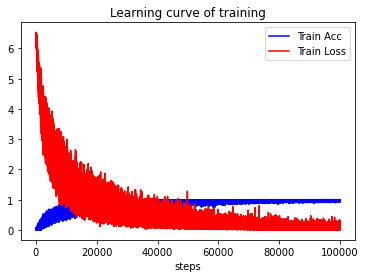

In [13]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(train_acc_record))
train_acc = torch.tensor(train_acc_record, device='cpu')
train_loss = torch.tensor(train_loss_record, device='cpu')

plt.title("Learning curve of training")
plt.xlabel("steps")
plt.plot(x, train_acc, color="blue", label="Train Acc")
plt.plot(x, train_loss, color="red", label="Train Loss")
plt.legend(loc="best")
plt.show()

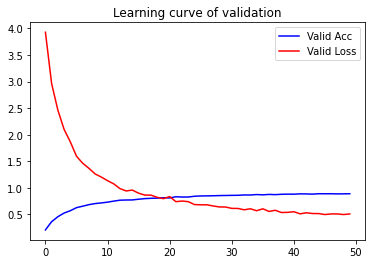

In [14]:
x = np.arange(len(valid_acc_record))
valid_acc = torch.tensor(valid_acc_record, device='cpu')
valid_loss = torch.tensor(valid_loss_record, device='cpu')

plt.title("Learning curve of validation")
plt.plot(x, valid_acc, color="blue", label="Valid Acc")
plt.plot(x, valid_loss, color="red", label="Valid Loss")
plt.legend(loc="best")
plt.show()

In [15]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()